In [49]:
import pandas as pd
import numpy as np
import requests
import xlsxwriter
import math
import pandas_datareader.data as web
import datetime
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

In [34]:
df1 = pd.read_csv('ArabicaData.csv', index_col='Date', dtype={'Price': np.float64})


df2 = pd.read_csv('RobustaData.csv', index_col='Date')
df2["Price"] = df2["Price"].replace(",", "", regex=True)
df2['Price'] = pd.to_numeric(df2['Price'], errors='coerce')

arabica_adj_price = df1['Price'] / 100
robusta_adj_price = df2['Price'] / 2204.62262 # converting price to cents/lbs

arabica_notional = arabica_adj_price * 375
robusta_notional = robusta_adj_price * 10 # notional value 

spread = arabica_adj_price - robusta_adj_price
spread.index = pd.to_datetime(spread.index)
spread = spread.sort_index()
spread_mean = spread.mean()
print('Mean spread value:', spread_mean)

if len(arabica_adj_price) < len(robusta_adj_price):
    robusta_adj_price = robusta_adj_price[:len(arabica_adj_price)]
    

Mean spread value: 0.6333726399348929


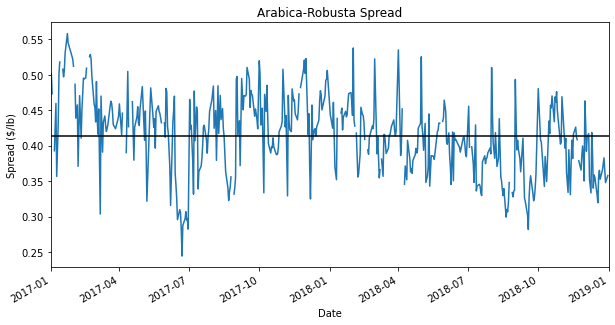

In [63]:
spread[start_date:end_date].plot(figsize=(10,5))
spread_interval_mean = spread[start_date:end_date].mean()

plt.title('Arabica-Robusta Spread')
plt.xlabel('Date')
plt.ylabel('Spread ($/lb)')
plt.axhline(spread_interval_mean, color = 'black')

# Set the x-axis limits to the date range
plt.xlim(start_date , end_date)
# Display the plot
plt.show()

In [36]:
start_date = start_date = pd.to_datetime('01/01/2017')
end_date = pd.to_datetime('01/01/2019')

In [59]:
df1.index = pd.to_datetime(df1.index)
df2.index = pd.to_datetime(df2.index)

df1_filtered = df1.loc[(df1.index >= start_date) & (df1.index < end_date)]
df2_filtered = df2.loc[(df2.index >= start_date) & (df2.index < end_date)]

# Compute adjusted prices and spread for the filtered data
arabica_adj_price = df1_filtered['Price'] / 100
robusta_adj_price = df2_filtered['Price'] / 2204.62262 # converting price to cents/lbs

spread = arabica_adj_price - robusta_adj_price
spread_mean = spread.mean()

print('Mean spread value:', spread_mean)

if len(arabica_adj_price) < len(robusta_adj_price):
    robusta_adj_price = robusta_adj_price[:len(arabica_adj_price)]



Date
2018-12-31    1524.984353
2018-12-28    1527.984322
2018-12-27    1507.984528
2018-12-26    1514.984456
2018-12-24    1514.984456
                 ...     
2017-06-01    2139.978043
2017-05-01    2153.977899
2017-04-01    2164.977787
2017-03-01    2123.978207
2017-02-01    2137.978064
Name: Price, Length: 510, dtype: float64
Mean spread value: 0.41435111647358464


In [38]:
score, pvalue, _ = coint(arabica_adj_price, robusta_adj_price)
print(pvalue) #prices are now cointegrated over the time interval 

0.0008568031172006842


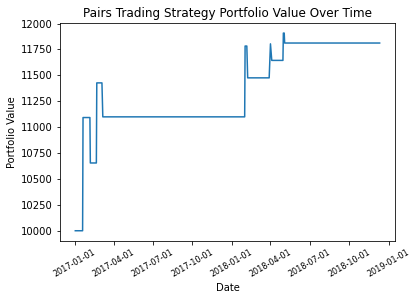

In [72]:
cash = 10000
units_arabica = 0
units_robusta = 0
in_trade = False
trade_direction = 0
spread_mean = spread.mean()
spread_std = spread.std()
entry_index = i  

portfolio_values = []
dates = []

arabica_margin = 7000
robusta_margin = 2500
arabica_point_value = 375
robusta_point_value = 10

# loop through each day
for i in range(min(len(arabica_adj_price), len(robusta_adj_price))):
    # calculate number of contracts that can be bought based on cash and margin requirements
    max_units_arabica = int(cash / arabica_margin)
    max_units_robusta = max_units_arabica / 1.7
    
    # if not in trade and spread is greater than 2 standard deviations, initiate a trade
    if not in_trade and spread[i] > spread_mean + 2 * spread_std:
        # calculate number of units to trade based on the spread and contract sizes
        n = spread[i] / (arabica_adj_price[i] - robusta_adj_price[i])
        units_arabica = int(cash/arabica_margin)
        units_robusta = units_arabica / 1.7
        
        
        # calculate cost of entering the trade (initial margin)
        cost_arabica = units_arabica * arabica_margin
        cost_robusta = units_robusta * robusta_margin
        total_cost = cost_arabica + cost_robusta
        # calculate profit from the trade (difference in prices at entry and exit)
        profit_arabica = abs(units_arabica * (arabica_adj_price[i] - arabica_adj_price[entry_index])*375)
        profit_robusta = abs(units_robusta * (robusta_adj_price[i] - robusta_adj_price[entry_index])*2204)
        total_profit = profit_arabica + profit_robusta
        
        # update cash and trade status
        cash += total_profit
        in_trade = True
        trade_direction = 1
        
        # print trade details
   #     print("Buy {} units of Arabica and sell {} units of Robusta at date {}".format(units_arabica, -units_robusta, spread.index[i]))
    # if in trade and spread is less than or equal to mean, close the trade
    elif in_trade and spread[i] <= spread_mean:
        # calculate number of units to trade based on the spread and contract sizes
        n = spread[i] / (arabica_adj_price[i] - robusta_adj_price[i])
        units_arabica = trade_direction * max_units_arabica
        units_robusta = int(units_arabica/1.7)
        
        # calculate profit from the trade (difference in prices at entry and exit)
        profit_arabica = abs(units_arabica * (arabica_adj_price[i] - arabica_adj_price[entry_index])*arabica_point_value)
        profit_robusta = abs(units_robusta * (robusta_adj_price[i] - robusta_adj_price[entry_index])*robusta_point_value*2204.62)
        total_profit = profit_arabica + profit_robusta
        
        cash += total_profit
        in_trade = False
        trade_direction = 0
        
 #       print("Sell {} units of Arabica and buy {} units of Robusta at date {}".format(units_arabica, -units_robusta, spread.index[i]))
        
    # calculate total portfolio value and append to the lists
    if not in_trade:
        portfolio_value = cash
    else:
        portfolio_value = cash + profit_robusta + profit_arabica
    portfolio_values.append(portfolio_value)
    dates.append(spread.index[i]) 
   #print("portfolio value at date", spread.index[i], "is", portfolio_value)
    #plot portfolio value over time

# Plot the portfolio values
fig, ax = plt.subplots()
ax.plot(dates, portfolio_values)

# Format the x-axis to show dates in a readable format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=8)

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.set_title('Pairs Trading Strategy Portfolio Value Over Time')

# Show the plot
plt.show()


11812.155517906634
